D:\kepler_ptf_research\k2_c1\python_Kepler_data_k2c1
Filename: ktwo201917390-c01_llc.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU      54   ()              
1    LIGHTCURVE  BinTableHDU    155   4022R x 20C   [D, E, J, E, E, E, E, E, E, J, D, E, D, E, D, E, D, E, E, E]   
2    APERTURE    ImageHDU        48   (18, 18)     int32   
None


C:\Users\CareyJohn\Anaconda3\lib\site-packages\pyfits\util.py:893: UserWarning: Could not find appropriate MS Visual C Runtime library or library is corrupt/misconfigured; cannot determine whether your file object was opened in append mode.  Please consider using a file object opened in write mode instead.
  'Could not find appropriate MS Visual C Runtime '


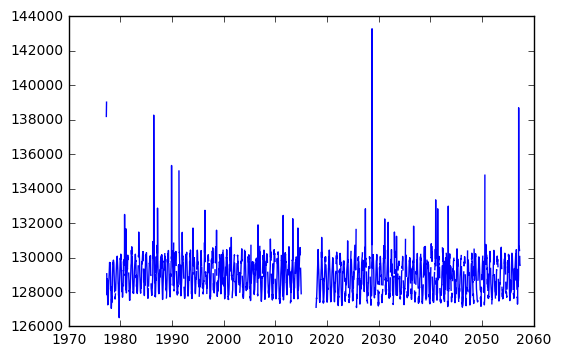

In [3]:
import pyfits, os
from matplotlib import pyplot as plt
import pyfits, os, sys, matplotlib, pylab
import numpy as np
from gatspy import periodic

#os.chdir("C:\\Users\\CareyJohn\\kplr_data_test")  #change directory
#os.chdir("/media/careyjohn/OS/Users/CareyJohn/Desktop/PSROC_klpr/K2_LLC_FITS/k2_camp1/ktwo201323410_C1")

def k2_llc_analysis(epic):

    ID = "ktwo"+str(epic)

    #os.chdir("C:/Users/CareyJohn/Desktop/PSROC_klpr/K2_LLC_FITS/k2_camp1/"+ID+"_C1")
    #os.chdir("D:/kepler_ptf_research/k2_c1/python_Kepler_data_k2c1"+ID+"_C1")
    os.chdir("D:/kepler_ptf_research/k2_c1/python_Kepler_data_k2c1")
    #nowpath = os.getcwd()
    #print (nowpath)

    data = pyfits.open(ID+"-c01_llc.fits")  #open the kepler fits data
    print (data.info())

    time = data[1].data.field('TIME')
    sap_flux=data[1].data.field('SAP_FLUX')
    sap_flux_err=data[1].data.field('SAP_FLUX_ERR')
    pdcsap_flux=data[1].data.field('PDCSAP_FLUX')
    pdcsap_flux_err=data[1].data.field('PDCSAP_FLUX_ERR')


    #plt.plot(time,pdcsap_flux)
    #plt.show()

    lc=zip(time,sap_flux,sap_flux_err,pdcsap_flux,pdcsap_flux_err)  #zip the open data 

    #print(list(lc))
    #os.chdir("..")
    if not os.path.exists("ktwo"+str(epic)+"_C1"):
        os.mkdir("ktwo"+str(epic)+"_C1")
        
    os.chdir("ktwo"+str(epic)+"_C1")
    
    output_file = ID+"-c01_llc.fits.lc"  #write the zip of the open data in a text book
    out = open(output_file,'w')
    for i in lc:
        write = '%s %s %s %s %s' %(i[0],i[1],i[2],i[3],i[4])
        out.write(write+'\n')
    out.close()
    
    filej = open( ID+"-c01_llc.fits.lc")

    datar = np.loadtxt( filej, dtype={'names':('time', '2', '3', 'flux', 'err'), 'formats':('f4','f4','f4','f4','f4')})
    
    
    
    masknan = -np.isnan(datar['flux']) # 遮閉掉nan的值, 加上'-'號是為了讓nan=false;數值=true
    masknan_err = -np.isnan(datar['err'])

    #print(data['flux'])
    #print(np.isnan(data['flux']))
    #print(masknan)
    #print(data['flux'][masknan])

    time = datar['time'][masknan]
    flux = datar['flux'][masknan]/np.mean(datar['flux'][masknan])  # 之後會被動手腳
    flux_raw = datar['flux'][masknan]/np.mean(datar['flux'][masknan])# 為了上一個而留下的替代品
    err = datar['err'][masknan_err]/np.mean(datar['err'][masknan])
    #print(time)
    #print(flux)
    #print(flux_raw)

    fluxC = np.zeros(len(flux))
    errC = np.zeros(len(err))
    
    separationtime=[]
    separationtime.append(0)

    for i in range(len(time)-1):
        if time[i+1]-time[i] > 3*(time[2]-time[1]):
            separationtime.append(i)
    separationtime.append(len(time))
    binsize = 10
    for k in range(len(separationtime)-1):
        #print(k)
        #take 10 points mean and replace it 
        for i in range(separationtime[k],separationtime[k+1]):

            if i >= (separationtime[k]+binsize) and i <= (separationtime[k+1]-binsize):
                fluxC[i] = np.median(flux[i-binsize:i+binsize])
                errC[i] = np.median(flux[i-binsize:i+binsize])
            else:
                fluxC[i] = flux[i]
                errC[i] = err[i]
        #plt.plot(time,flux_raw)
        #plt.scatter(time,flux_raw)
        #plt.plot(time,fluxC)
        #plt.scatter(time,fluxC)
        #plt.show()
        #plt.clf()
        #print (fluxC)
        #print (flux_raw)

        #obseverd subtract calculate
        fluxdiff = flux - fluxC

        #remove the peak value which > 1 sigam
        maskpeak = fluxdiff > 1.0*fluxdiff.std()

        for n,i in enumerate(maskpeak):
            if i:
                if n >= (separationtime[k]+binsize) and n <= (separationtime[k+1]-binsize):
                    flux[n] = np.median(flux[n-binsize:n+binsize])
                else:
                    flux[n] = flux[n]
    #plt.plot(time,flux_raw, 'r')
    #plt.plot(time,flux_raw, '.')
    #plt.scatter(time,flux_raw)
    #plt.plot(time,fluxC)
    #plt.scatter(time,fluxC)
    #plt.xlabel('Time(BJD - 2454833)')
    #plt.ylabel('Normalized flux')
    #plt.xlim(1976,1980)
    #plt.show()
    #plt.clf()
    #print (fluxC)
    #print (flux_raw)
    
    model = periodic.LombScargle(fit_period = True)

    model.optimizer.period_range = ( 0.1, 80.0)

    model.fit(time, flux);

    model.best_period

    P = model.best_period

    print(P)

[(1975.178466796875, nan, nan, nan, nan)
 (1975.1988525390625, nan, nan, nan, nan)
 (1975.21923828125, nan, nan, nan, nan) ...,
 (2057.2939453125, 127431.0, 11.907400131225586, 129653.0, 12.459500312805176)
 (2057.314453125, 127651.0, 11.916600227355957, 129612.0, 12.470000267028809)
 (2057.334716796875, 128144.0, 11.942099571228027, 129548.0, 12.49940013885498)]


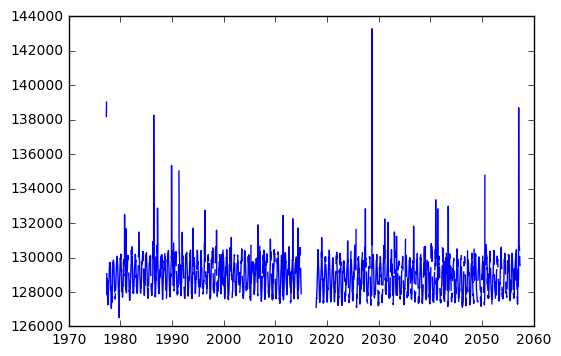

In [4]:


#os.chdir("/media/careyjohn/OS/Users/CareyJohn/Desktop/PSROC_klpr/K2_LLC_FITS/k2_camp1/ktwo201323410_C1")

#os.chdir("C:/Users/CareyJohn/Desktop/PSROC_klpr/K2_LLC_FITS/k2_camp1/ktwo201568682_C1")

filej = open( ID+"-c01_llc.fits.lc")

datar = np.loadtxt( filej, dtype={'names':('time', '2', '3', 'flux', 'err'), 'formats':('f4','f4','f4','f4','f4')})

print(datar)

plt.plot(datar['time'],datar['flux'])
plt.show()

In [7]:
masknan = -np.isnan(datar['flux']) # 遮閉掉nan的值, 加上'-'號是為了讓nan=false;數值=true
masknan_err = -np.isnan(datar['err'])

#print(data['flux'])
#print(np.isnan(data['flux']))
#print(masknan)
#print(data['flux'][masknan])

time = datar['time'][masknan]
flux = datar['flux'][masknan]/np.mean(datar['flux'][masknan])  # 之後會被動手腳
flux_raw = datar['flux'][masknan]/np.mean(datar['flux'][masknan])# 為了上一個而留下的替代品
err = datar['err'][masknan_err]/np.mean(datar['err'][masknan])
#print(time)
#print(flux)
#print(flux_raw)

C:\Users\CareyJohn\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  if __name__ == '__main__':
C:\Users\CareyJohn\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.
  from ipykernel import kernelapp as app


In [8]:
fluxC = np.zeros(len(flux))
errC = np.zeros(len(err))

print(fluxC)
print(errC)

[ 0.  0.  0. ...,  0.  0.  0.]
[ 0.  0.  0. ...,  0.  0.  0.]


In [9]:
separationtime=[]
separationtime.append(0)

for i in range(len(time)-1):
    if time[i+1]-time[i] > 3*(time[2]-time[1]):
        separationtime.append(i)
separationtime.append(len(time))
print (separationtime)

[0, 202, 362, 543, 1450, 1759, 2037, 2125, 2237, 2532, 2741, 2806, 2828, 3248, 3359, 3552]


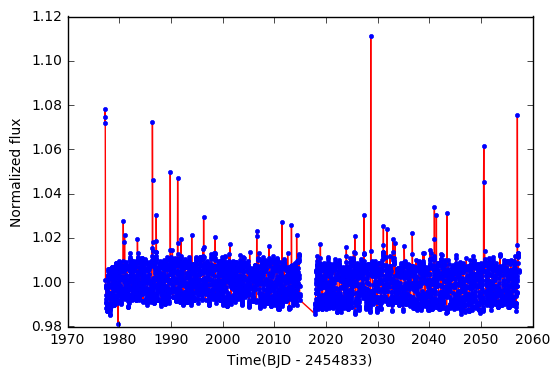

In [11]:
#for j in range(2):
binsize = 10
for k in range(len(separationtime)-1):
    #print(k)
    #take 10 points mean and replace it 
    for i in range(separationtime[k],separationtime[k+1]):
        
        if i >= (separationtime[k]+binsize) and i <= (separationtime[k+1]-binsize):
            fluxC[i] = np.median(flux[i-binsize:i+binsize])
            errC[i] = np.median(flux[i-binsize:i+binsize])
        else:
            fluxC[i] = flux[i]
            errC[i] = err[i]
    #plt.plot(time,flux_raw)
    #plt.scatter(time,flux_raw)
    #plt.plot(time,fluxC)
    #plt.scatter(time,fluxC)
    #plt.show()
    #plt.clf()
    #print (fluxC)
    #print (flux_raw)
        
    #obseverd subtract calculate
    fluxdiff = flux - fluxC
    
    #remove the peak value which > 1 sigam
    maskpeak = fluxdiff > 1.0*fluxdiff.std()
    
    for n,i in enumerate(maskpeak):
        if i:
            if n >= (separationtime[k]+binsize) and n <= (separationtime[k+1]-binsize):
                flux[n] = np.median(flux[n-binsize:n+binsize])
            else:
                flux[n] = flux[n]
plt.plot(time,flux_raw, 'r')
plt.plot(time,flux_raw, '.')
#plt.scatter(time,flux_raw)
#plt.plot(time,fluxC)
#plt.scatter(time,fluxC)
plt.xlabel('Time(BJD - 2454833)')
plt.ylabel('Normalized flux')
#plt.xlim(1976,1980)
plt.show()
plt.clf()
#print (fluxC)
#print (flux_raw)

Finding optimal frequency:
 - Estimated peak width = 0.0785
 - Using 5 steps per peak; omega_step = 0.0157
 - User-specified period range:  0.1 to 80
 - Computing periods at 4000 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
0.707796710433


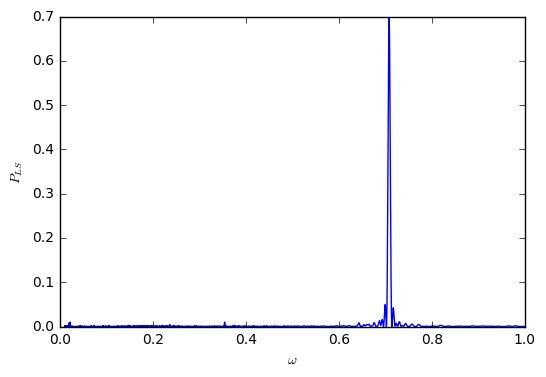

In [12]:
model = periodic.LombScargle(fit_period = True)

model.optimizer.period_range = ( 0.1, 80.0)

model.fit(time, flux);

model.best_period

P = model.best_period

print(P)

periods = np.linspace(0.01,1.0, 10000)

scores = model.score(periods)

plt.plot(periods, scores)

plt.xlabel('$\omega$')
plt.ylabel('$P_{LS}$')

plt.show()

plt.clf()

In [17]:
#To fine when is the minimum flux time,the moment I assume to be the zero time in this study 
minvalue = np.min(flux_raw)
for i in range(len(flux_raw)):
    if flux_raw[i] == minvalue:
        t0 = i
print('t0 = %f' %time[t0])
t_start = time[t0]

t0 = 1979.755249


In [18]:
# define function to phase lightcurves 。
def phase(time, periods, t0):
    """ Given an input array of times and a period, return the corresponding phase."""
    #return (time - t0) % periods / periods
    return (time - t0) % periods / periods

In [23]:
def plot_phased_lc(data, periods, t0, color='red'):
    phases = phase(time, periods, t_start)
    plt.errorbar(phases, flux_raw, color='b', fmt = '_', capsize=0)
    plt.ylim(np.min(flux_raw) , np.max(flux_raw)  )
    #plt.ylim(0.990 , np.max(flux_raw)  )
    plt.xlabel('Phase')
    plt.ylabel('Normalized flux')
    plt.show()

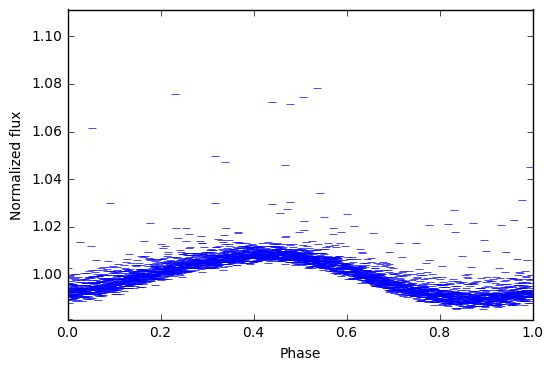

In [25]:
plot_phased_lc(datar, P, 1977.303711 )